In [1]:
%matplotlib inline

import argparse
import glob
import math
import ntpath
import shutil
import random, os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dhedfreader
import mne
import pyeeg
import warnings
warnings.filterwarnings('ignore')

from matplotlib.backends.backend_pdf import PdfPages
from mne.datasets.sleep_physionet._utils import _fetch_one, _data_path, AGE_SLEEP_RECORDS, _check_subjects
from datetime import datetime
from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import psd_welch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from tqdm.notebook import tqdm

VBS = False
EPOCH_SEC_SIZE = 30

# Label values
W = 0
N1 = 1
N2 = 2
N3 = 3
REM = 4
UNKNOWN = 5

stage_dict = {
    "W": W,
    "N1": N1,
    "N2": N2,
    "N3": N3,
    "REM": REM,
    "UNKNOWN": UNKNOWN
}

class_dict = {
    0: "W",
    1: "N1",
    2: "N2",
    3: "N3",
    4: "REM",
    5: "UNKNOWN"
}

ann2label = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
    "Sleep stage ?": 5,
    "Movement time": 5
}
project_path = os.path.abspath(os.getcwd())
print(project_path)

C:\Users\pratik\Desktop\DM Project\New folder


In [2]:
data_path = _data_path

BASE_URL = 'https://physionet.org/physiobank/database/sleep-edfx/sleep-cassette/'  # noqa: E501

def fetch_data(subjects, recording=[1, 2], path=None, force_update=False,
               update_path=None, base_url=BASE_URL,
               verbose=None):  # noqa: D301
    records = np.loadtxt(AGE_SLEEP_RECORDS,
                         skiprows=1,
                         delimiter=',',
                         usecols=(0, 1, 2, 6, 7),
                         dtype={'names': ('subject', 'record', 'type', 'sha',
                                          'fname'),
                                'formats': ('<i2', 'i1', '<S9', 'S40', '<S22')}
                         )
    psg_records = records[np.where(records['type'] == b'PSG')]
    hyp_records = records[np.where(records['type'] == b'Hypnogram')]

    path = data_path(path=path, update_path=update_path)
    params = [path, force_update, base_url]
    fnames = []
    for subject in subjects:
        for idx in np.where(psg_records['subject'] == subject)[0]:
            if psg_records['record'][idx] in recording:
                psg_fname = _fetch_one(psg_records['fname'][idx].decode(),
                                       psg_records['sha'][idx].decode(),
                                       *params)
                hyp_fname = _fetch_one(hyp_records['fname'][idx].decode(),
                                       hyp_records['sha'][idx].decode(),
                                       *params)
                fnames.append([psg_fname, hyp_fname])

    return fnames


In [3]:
subjects_list = []
for i in range(83):
    if i == 36 or i == 52:
        continue
    subjects_list.append(i)
subject_files = fetch_data(subjects=subjects_list, recording=[1, 2], path= project_path)
mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

In [4]:
ch_labels = 'EEG Fpz-Cz'
data_frames = []
print("Reading data to data frames:")
progress = len(subject_files)
raw_train = None
output_path = os.path.join(project_path, "NPZ_files")

for item in tqdm(subject_files):
    raw_train = mne.io.read_raw_edf(item[0], verbose=VBS)
    sampling_rate = raw_train.info['sfreq']
    raw_ch_df = raw_train.to_data_frame(scaling_time=100.0)[ch_labels]
    raw_ch_df = raw_ch_df.to_frame()
    raw_ch_df.set_index(np.arange(len(raw_ch_df)))

    # Get raw header
    f = open(item[0], 'r', errors='ignore', encoding='utf-8')
    reader_raw = dhedfreader.BaseEDFReader(f)
    reader_raw.read_header()
    h_raw = reader_raw.header
    f.close()
    raw_start_dt = datetime.strptime(h_raw['date_time'], "%Y-%m-%d %H:%M:%S")

    # Read annotation and its header
    f = open(item[1], 'r')
    reader_ann = dhedfreader.BaseEDFReader(f)
    reader_ann.read_header()
    h_ann = reader_ann.header
    _, _, ann = zip(*reader_ann.records())
    f.close()
    ann_start_dt = datetime.strptime(h_ann['date_time'], "%Y-%m-%d %H:%M:%S")

    # Assert that raw and annotation files start at the same time
    assert raw_start_dt == ann_start_dt

    # Generate label and remove indices
    remove_idx = []    # indicies of the data that will be removed
    labels = []        # indicies of the data that have labels
    label_idx = []
    for a in ann[0]:
        onset_sec, duration_sec, ann_char = a
        ann_str = "".join(ann_char)
        label = ann2label[ann_str]
        if label != UNKNOWN:
            if duration_sec % EPOCH_SEC_SIZE != 0:
                raise Exception("Something wrong")
            duration_epoch = int(duration_sec / EPOCH_SEC_SIZE)
            label_epoch = np.ones(duration_epoch, dtype=np.int) * label
            labels.append(label_epoch)
            idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
            label_idx.append(idx)
            if VBS:
                print("Include onset:{}, duration:{}, label:{} ({})"
                      .format(onset_sec, duration_sec, label, ann_str))
        else:
            idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
            remove_idx.append(idx)
            if VBS:
                print("Remove onset:{}, duration:{}, label:{} ({})"
                      .format(onset_sec, duration_sec, label, ann_str))
    labels = np.hstack(labels)
    if VBS:
        print("before remove unwanted: {}".format(np.arange(len(raw_ch_df)).shape))
    if len(remove_idx) > 0:
        remove_idx = np.hstack(remove_idx)
        select_idx = np.setdiff1d(np.arange(len(raw_ch_df)), remove_idx)
    else:
        select_idx = np.arange(len(raw_ch_df))
    if VBS:
        print("after remove unwanted: {}".format(select_idx.shape))

    # Select only the data with labels
    if VBS:
        print("before intersect label: {}".format(select_idx.shape))
    label_idx = np.hstack(label_idx)
    select_idx = np.intersect1d(select_idx, label_idx)
    if VBS:
        print("after intersect label: {}".format(select_idx.shape))

    # Remove extra index
    if len(label_idx) > len(select_idx):
        if VBS:
            print("before remove extra labels: {}, {}".format(select_idx.shape, labels.shape))
        extra_idx = np.setdiff1d(label_idx, select_idx)
        # Trim the tail
        if np.all(extra_idx > select_idx[-1]):
            n_trims = len(select_idx) % int(EPOCH_SEC_SIZE * sampling_rate)
            n_label_trims = int(math.ceil(n_trims / (EPOCH_SEC_SIZE * sampling_rate)))
            select_idx = select_idx[:-n_trims]
            labels = labels[:-n_label_trims]
        if VBS:
            print("after remove extra labels: {}, {}".format(select_idx.shape, labels.shape))

    # Remove movement and unknown stages if any
    raw_ch = raw_ch_df.values[select_idx]

    # Verify that we can split into 30-s epochs
    if len(raw_ch) % (EPOCH_SEC_SIZE * sampling_rate) != 0:
        raise Exception("Something wrong")
    n_epochs = len(raw_ch) / (EPOCH_SEC_SIZE * sampling_rate)

    # Get epochs and their corresponding labels
    x = np.asarray(np.split(raw_ch, n_epochs)).astype(np.float32)
    y = labels.astype(np.int32)

    assert len(x) == len(y)

    # Select on sleep periods
    w_edge_mins = 30
    nw_idx = np.where(y != stage_dict["W"])[0]
    start_idx = nw_idx[0] - (w_edge_mins * 2)
    end_idx = nw_idx[-1] + (w_edge_mins * 2)
    if start_idx < 0: start_idx = 0
    if end_idx >= len(y): end_idx = len(y) - 1
    select_idx = np.arange(start_idx, end_idx+1)
    if VBS:
        print("Data before selection: {}, {}".format(x.shape, y.shape))
    x = x[select_idx]
    y = y[select_idx]
    if VBS:
        print("Data after selection: {}, {}".format(x.shape, y.shape))

    # Save
    filename = ntpath.basename(item[0]).replace("-PSG.edf", ".npz")
    save_dict = {
        "x": x, 
        "y": y, 
        "fs": sampling_rate,
        "ch_label": ch_labels,
        "header_raw": h_raw,
        "header_annotation": h_ann,
    }
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    if not os.path.exists(os.path.join(output_path, filename)):
        try:
            np.savez(os.path.join(output_path, filename), **save_dict)    
        except:
            print(item)

data_frames = raw_train.to_data_frame()

Reading data to data frames:


ImportError: FloatProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
raw_train = mne.io.read_raw_edf(item[0], verbose=VBS)
annot_train = mne.read_annotations(item[1])

raw_train.set_annotations(annot_train, emit_warning=False)
raw_train.set_channel_types(mapping)

#plot some data
raw_train.plot(duration=60, scalings='auto')

annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

# create a new event_id that unifies stages 3 and 4
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

# plot events
mne.viz.plot_events(events_train, event_id=event_id,
                    sfreq=raw_train.info['sfreq'])

# keep the color-code for further plotting
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included

epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                          event_id=event_id, tmin=0., tmax=tmax, baseline=None)

print(epochs_train)

In [8]:
for item in subject_files:
    raw_test = mne.io.read_raw_edf(item[0])
    annot_test = mne.read_annotations(item[1])
    raw_test.set_annotations(annot_test, emit_warning=False)
    raw_test.set_channel_types(mapping)
    events_test, _ = mne.events_from_annotations(
        raw_test, event_id=annotation_desc_2_event_id, chunk_duration=30.)
    print("event ID: ", events_test)
    epochs_test = mne.Epochs(raw=raw_test, events=events_test, event_id=event_id,
                             tmin=0., tmax=tmax, baseline=None)

    print(epochs_test)

Extracting EDF parameters from C:\Users\pratik\Desktop\DM Project\New folder\physionet-sleep-data\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
event ID:  [[      0       0       1]
 [   3000       0       1]
 [   6000       0       1]
 ...
 [7941000       0       1]
 [7944000       0       1]
 [7947000       0       1]]
2650 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
<Epochs  |   2650 events (good & bad), 0 - 29.99 sec, baseline off, ~19 kB, data not loaded,
 'Sleep stage 1': 58
 'Sleep stage 2': 250
 'Sleep stage 3/4': 220
 'Sleep stage R': 125
 'Sleep stage W': 1997>
Extracting EDF parameters from C:\Users\pratik\Desktop\DM Project\New folder\physionet-sleep-data\SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Cr

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
event ID:  [[      0       0       1]
 [   3000       0       1]
 [   6000       0       1]
 ...
 [8157000       0       1]
 [8160000       0       1]
 [8163000       0       1]]
2722 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
<Epochs  |   2722 events (good & bad), 0 - 29.99 sec, baseline off, ~19 kB, data not loaded,
 'Sleep stage 1': 44
 'Sleep stage 2': 217
 'Sleep stage 3/4': 135
 'Sleep stage R': 68
 'Sleep stage W': 2258>
Extracting EDF parameters from C:\Users\pratik\Desktop\DM Project\New folder\physionet-sleep-data\SC4052E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
event ID:  [[      0       0       1]
 [   3000       0       1]
 [   6000       0       1]
 ...
 [8151000       0       1]
 [8154000       0       1]
 [8157000       0       1]]
2719 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
<Epochs  |   2719 events (good & bad), 0 - 29.99 sec, baseline off, ~19 kB, data not loaded,
 'Sleep stage 1': 65
 'Sleep stage 2': 671
 'Sleep stage 3/4': 6
 'Sleep stage R': 207
 'Sleep stage W': 1770>
Extracting EDF parameters from C:\Users\pratik\Desktop\DM Project\New folder\physionet-sleep-data\SC4102E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep s

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
event ID:  [[      0       0       1]
 [   3000       0       1]
 [   6000       0       1]
 ...
 [8583000       0       1]
 [8586000       0       1]
 [8589000       0       1]]
2859 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
<Epochs  |   2859 events (good & bad), 0 - 29.99 sec, baseline off, ~19 kB, data not loaded,
 'Sleep stage 1': 47
 'Sleep stage 2': 438
 'Sleep stage 3/4': 178
 'Sleep stage R': 292
 'Sleep stage W': 1904>
Extracting EDF parameters from C:\Users\pratik\Desktop\DM Project\New folder\physionet-sleep-data\SC4161E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
event ID:  [[      0       0       1]
 [   3000       0       1]
 [   6000       0       1]
 ...
 [8001000       0       1]
 [8004000       0       1]
 [8007000       0       1]]


ValueError: No matching events found for Sleep stage 3/4 (event id 4)

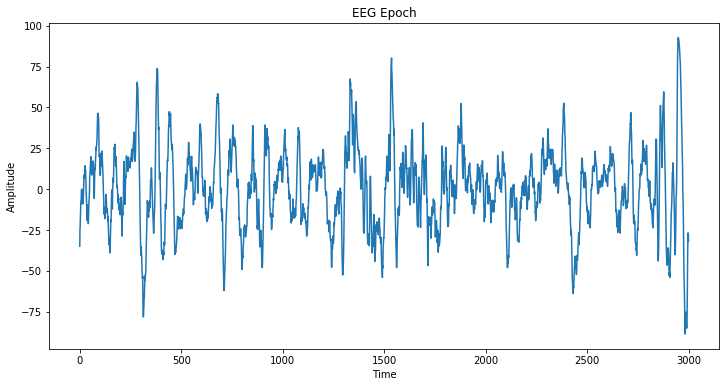

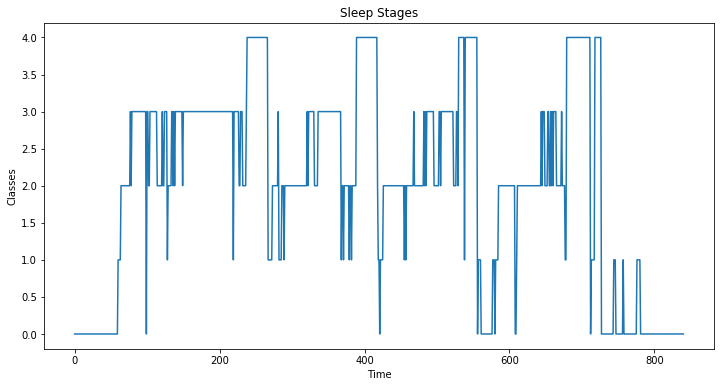

In [6]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import collections
#import librosa
data = np.load(path)
x = data['x']
y = data['y']
fig_1 = plt.figure(figsize=(12, 6))
plt.plot(x[100, ...].ravel())
plt.title("EEG Epoch")
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()
fig_2 = plt.figure(figsize=(12, 6))
plt.plot(y.ravel())
plt.title("Sleep Stages")
plt.ylabel("Classes")
plt.xlabel("Time")
plt.show()

In [7]:
import numpy as np
from glob import glob
import os
from sklearn.model_selection import train_test_split
base_path = project_path+'/NPZ_files'
files = glob(os.path.join(base_path, "*.npz"))
train_val, test = train_test_split(files, test_size=0.15, random_state=1337)
train, val = train_test_split(train_val, test_size=0.1, random_state=1337)
train_dict = {k: np.load(k) for k in train}
test_dict = {k: np.load(k) for k in test}
val_dict = {k: np.load(k) for k in val}

In [8]:
import random
WINDOW_SIZE = 100
def rescale_array(X):
    X = X / 20
    X = np.clip(X, -5, 5)
    return X

def aug_X(X):
    scale = 1 + np.random.uniform(-0.1, 0.1)
    offset = np.random.uniform(-0.1, 0.1)
    noise = np.random.normal(scale=0.05, size=X.shape)
    X = scale * X + offset + noise
    return X

def gen(dict_files, aug=False):
    while True:
        record_name = random.choice(list(dict_files.keys()))
        batch_data = dict_files[record_name]
        all_rows = batch_data['x']
        for i in range(10):
            start_index = random.choice(range(all_rows.shape[0]-WINDOW_SIZE))
            X = all_rows[start_index:start_index+WINDOW_SIZE, ...]
            Y = batch_data['y'][start_index:start_index+WINDOW_SIZE]
            X = np.expand_dims(X, 0)
            Y = np.expand_dims(Y, -1)
            Y = np.expand_dims(Y, 0)
            if aug:
                X = aug_X(X)
            X = rescale_array(X)
            yield X, Y

def chunker(seq, size=WINDOW_SIZE):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [9]:
from keras import optimizers, losses, activations, models
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate, SpatialDropout1D, TimeDistributed, Bidirectional, LSTM
from keras_contrib.layers import CRF
from utils import WINDOW_SIZE

def get_model():
    nclass = 5
    inp = Input(shape=(3000, 1))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = SpatialDropout1D(rate=0.01)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = SpatialDropout1D(rate=0.01)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = SpatialDropout1D(rate=0.01)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.01)(img_1)
    dense_1 = Dropout(rate=0.01)(Dense(64, activation=activations.relu, name="dense_1")(img_1))
    dense_1 = Dropout(rate=0.05)(Dense(64, activation=activations.relu, name="dense_2")(dense_1))
    dense_1 = Dense(nclass, activation=activations.softmax, name="dense_3")(dense_1)
    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

def get_base_model():
    inp = Input(shape=(3000, 1))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = SpatialDropout1D(rate=0.01)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = SpatialDropout1D(rate=0.01)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = SpatialDropout1D(rate=0.01)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.01)(img_1)
    dense_1 = Dropout(0.01)(Dense(64, activation=activations.relu, name="dense_1")(img_1))
    base_model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)
    base_model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    #model.summary()
    return base_model

def get_model_cnn():
    nclass = 5
    seq_input = Input(shape=(None, 3000, 1))
    base_model = get_base_model()
    # for layer in base_model.layers:
    #     layer.trainable = False
    encoded_sequence = TimeDistributed(base_model)(seq_input)
    encoded_sequence = SpatialDropout1D(rate=0.01)(Convolution1D(128,
                                                               kernel_size=3,
                                                               activation="relu",
                                                               padding="same")(encoded_sequence))
    encoded_sequence = Dropout(rate=0.05)(Convolution1D(128,
                                                               kernel_size=3,
                                                               activation="relu",
                                                               padding="same")(encoded_sequence))
    #out = TimeDistributed(Dense(nclass, activation="softmax"))(encoded_sequence)
    out = Convolution1D(nclass, kernel_size=3, activation="softmax", padding="same")(encoded_sequence)
    model = models.Model(seq_input, out)
    model.compile(optimizers.Adam(0.001), losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

def get_model_lstm():
    nclass = 5
    seq_input = Input(shape=(None, 3000, 1))
    base_model = get_base_model()
    for layer in base_model.layers:
        layer.trainable = False
    encoded_sequence = TimeDistributed(base_model)(seq_input)
    encoded_sequence = Bidirectional(LSTM(100, return_sequences=True))(encoded_sequence)
    encoded_sequence = Dropout(rate=0.5)(encoded_sequence)
    encoded_sequence = Bidirectional(LSTM(100, return_sequences=True))(encoded_sequence)
    #out = TimeDistributed(Dense(nclass, activation="softmax"))(encoded_sequence)
    out = Convolution1D(nclass, kernel_size=1, activation="softmax", padding="same")(encoded_sequence)
    model = models.Model(seq_input, out)
    model.compile(optimizers.Adam(0.001), losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

def get_model_cnn_crf(lr=0.001):
    nclass = 5
    seq_input = Input(shape=(None, 3000, 1))
    base_model = get_base_model()
    # for layer in base_model.layers:
    #     layer.trainable = False
    encoded_sequence = TimeDistributed(base_model)(seq_input)
    encoded_sequence = SpatialDropout1D(rate=0.01)(Convolution1D(128,
                                                               kernel_size=3,
                                                               activation="relu",
                                                               padding="same")(encoded_sequence))
    encoded_sequence = Dropout(rate=0.05)(Convolution1D(128,
                                                               kernel_size=3,
                                                               activation="linear",
                                                               padding="same")(encoded_sequence))
    #out = TimeDistributed(Dense(nclass, activation="softmax"))(encoded_sequence)
    # out = Convolution1D(nclass, kernel_size=3, activation="linear", padding="same")(encoded_sequence)
    crf = CRF(nclass, sparse_target=True)
    out = crf(encoded_sequence)
    model = models.Model(seq_input, out)
    model.compile(optimizers.Adam(lr), crf.loss_function, metrics=[crf.accuracy])
    model.summary()
    return model

ModuleNotFoundError: No module named 'keras'